# 13 Reverse Quantum Annealing with Portfolio Optimization Problem as an example

## ポートフォリオ最適化問題
  資産運用して投資活動を行うとき、できるだけリスクを回避しながら大きな収益を実現させたい。なので、収益が限定的であるが、リスクが小さい（ないし全くない）資産と見込める収益が大きい分リスクも大きい資産を組み合わせてポートフォリオを作って分散投資を行うのが一般的な戦略になる。

  この時、与えられた一定のリスクでは最大利益を実現したい、または同じ利益を実現する場合できるだけ小さいリスクを取るには、最適なポートフォリオを選ぶ必要がある。現在、よく利用される手法はMarkowitzによる現代ポートフォリオ理論(Modern Portfolio Theory)であり、ポートフォリオを構成する銘柄の間の相関を考慮して、その共分散を最小にさせるような手法になる[1]。
  $$
  \min \sum_{i=1}^{N}\sum_{j=1}^{N}w_{i}w_{j}\sigma_{ij}; \quad \sum_{i=1}^{N}W_{i}=1; \quad \sum_{i=1}^{N}W_{i}\mu_{i}=R
  $$
  ただし、$w_{i}$は各銘柄がポートフォリオ内を占める重みで、$\sigma_{ij}$は銘柄間の共分散である。$\mu_{i}$は各銘柄の期待収益で、$R$はこのポートフォリオの総収益になる。



### Sharpe Ratio

## Reverse Quantum Annealingとは

## Open Jijにおける実装

実際に実装を行う前に、まずは実験用データの生成を行う。
論文[1]にある方法に従って、与えられた初期値を用いて、ブラウン運動によるチャートを生成する。

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

#Magic numbers to generate assets
rho = 0.1 # input uniform correlation
mu = 0.075 # expected value
sigma = 0.15 # volatility/standard error
r0 = 0.015 # no risk return

付録Aによって、各時刻においてチャートの運動は前の時刻の運動によって
$$
S(t_{n+1})=S(t_n)\exp(\mu-\frac{1}{2}\sigma^2)\Delta t + \sigma Z_n\sqrt{\Delta t}
$$
のように与えられる。ここの$Z_n$はcholesky分解で作られた一様相関行列$\rho$を従う多変量正規分布になる。

それを実行して適当にチャートをプロットして様子を確認する。全体として初期値から広がっていくが、一部銘柄が大きく上昇または降下するのも確認できる。

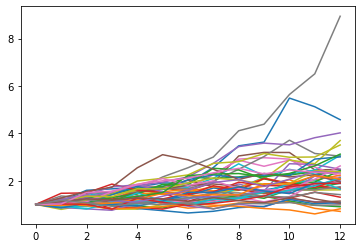

In [3]:
def createZvariables(N, rho):
  rho_mat = np.full((N,N), rho)
  rho_mat[range(N), range(N)] = 1.0
  rho_chole = np.linalg.cholesky(rho_mat)
  zNs_temp = np.random.normal(0, 1, (10000, N))
  zNs = zNs_temp @ rho_chole
  return zNs

def GetNextSt(St, mu, sigma, zN):
  Deltat = 1
  #zN = random.choice(zNs)
  scale = np.exp((mu-0.5*sigma*sigma)*Deltat + sigma*zN*np.sqrt(Deltat))
  NextSt = St * scale
  return NextSt

Nassets = 48
chart = list()
ZList = list()
Zvariables = createZvariables(Nassets, rho)
Zlabels = random.sample([x for x in range(10000)], 12)
for label in Zlabels:
  ZList.append(Zvariables[label])
for iasset in range(Nassets):
  chart_asset = [1.0]
  for month in range(12):
    chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))
  chart.append(chart_asset)
  #print(chart_asset)
  plt.plot(list(range(13)), chart_asset)
plt.show()

銘柄のチャートを生成できたので、Sharpe Ratioを計算する。ここ結果を評価するに使うのは実現Sharpe Ratioで、無リスク利回り率を超過した超過収益率の平均と超過収益率の標準偏差で求められる。チャートを確認するとき分かったように、銘柄数が少ない場合は偶然による偏りが大きいので、銘柄を10回生成してその平均Shape Ratioの確認をする。
結果として、銘柄の平均Sharpe Ratioが概ね0.4付近になるのを確認できる。

In [4]:

def CreateAssets(Nassets): 
  chart = list()
  ZList = list()
  Zvariables = createZvariables(Nassets, rho)
  Zlabels = random.sample([x for x in range(10000)], 12)
  for label in Zlabels:
    ZList.append(Zvariables[label])
  for iasset in range(Nassets):
    chart_asset = [1.0]
    for month in range(12):
      chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))
    chart.append(chart_asset)
  return chart

def CalculateSharpeRatio(asset):
  monthly_log_return = list()
  #monthly_return = list()
  for month in range(12):
    valueChange = asset[month+1]/asset[month] - 1.0 # 毎月の収益
    log_return = np.log(valueChange+1.0)
    monthly_log_return.append(log_return)
    #monthly_return.append(valueChange)

  mean_log_return = np.mean(monthly_log_return)
  log_volatility = np.std(monthly_log_return,ddof=1)

  #mean_return = np.mean(monthly_return)
  #volatility = np.std(monthly_return,ddof=1)


  return (mean_log_return-np.log(1+r0))/log_volatility
  #return (mean_return-r0)/volatility

allmean = 0
for ntry in range(10):
  Chart = CreateAssets(48)
  mean_SR = 0.0
  n = 0.
  for asset in Chart:
    assetSR = CalculateSharpeRatio(asset)
    mean_SR = ((mean_SR*n)+assetSR) / (n+1)
    n+=1
  print("SubSet "+ str(ntry)+ " average Sharpe Ratio: " + str(mean_SR))
  allmean = ((allmean*ntry)+mean_SR) / (ntry+1)
  print("Average Sharpe Ratio of all generated: "+ str(allmean))

SubSet 0 average Sharpe Ratio: 0.6797552849698256
Average Sharpe Ratio of all generated: 0.6797552849698256
SubSet 1 average Sharpe Ratio: 0.34512030219876716
Average Sharpe Ratio of all generated: 0.5124377935842964
SubSet 2 average Sharpe Ratio: 0.26714976984993305
Average Sharpe Ratio of all generated: 0.4306751190061753
SubSet 3 average Sharpe Ratio: 0.44235553113834297
Average Sharpe Ratio of all generated: 0.4335952220392172
SubSet 4 average Sharpe Ratio: 0.28623555467603395
Average Sharpe Ratio of all generated: 0.40412328856658053
SubSet 5 average Sharpe Ratio: 0.35969632769981813
Average Sharpe Ratio of all generated: 0.39671879508878677
SubSet 6 average Sharpe Ratio: 0.518734009738854
Average Sharpe Ratio of all generated: 0.4141495400387964
SubSet 7 average Sharpe Ratio: 0.266373400568605
Average Sharpe Ratio of all generated: 0.3956775226050225
SubSet 8 average Sharpe Ratio: 0.32558297963581756
Average Sharpe Ratio of all generated: 0.3878892400528886
SubSet 9 average Sharp

銘柄の確認ができてから、ポートフォリオを組んだ場合の確認を行う。論文に従い、大きな銘柄プールからある特定の数の銘柄をランダムに抽出してその実現Sharpe Ratioを計算する。
そのため、すでに作ってある関数で大きい銘柄数を持つ市場を生成する。

In [5]:
Nassets = 3826 #東証上場銘柄数 十分に大きければなんでも良いはず 
SizeOfPortfolio = 48

index_list = np.arange(Nassets)
Chart = CreateAssets(Nassets)

In [6]:
SR_list = list()
for ntry in range(100):
    selected_charts = list()
    choices = np.random.choice(index_list, size=SizeOfPortfolio, replace=False)
    chartSR_list = list()
    for ichart in choices:
        selected_charts.append(Chart[ichart])
        assetSR = CalculateSharpeRatio(Chart[ichart])
        chartSR_list.append(assetSR)
    print(np.min(chartSR_list),np.max(chartSR_list), np.mean(chartSR_list), np.percentile(chartSR_list, [25,75]))
    #print(np.mean(SR_list), np.percentile(SR_list, [25,75]))
    portfolioChart = np.mean(selected_charts, axis=0)
    print(portfolioChart)
    #print(portfolioChart)
    portfolioSR = CalculateSharpeRatio(portfolioChart)
    SR_list.append(portfolioSR)
    #plt.plot(list(range(13)), portfolioChart)
    #plt.show()
    #print(portfolioSR)
    #print(np.mean(SR_list), np.percentile(SR_list, [25,75]))


-0.14813437849543426 1.1452684779001132 0.3018204420747291 [0.07432202 0.47169812]
[1.         1.07248648 1.16602392 1.19224139 1.30500058 1.36193817
 1.45826319 1.50285588 1.60754797 1.75950945 1.80884737 1.97727122
 2.20725343]
-0.5300862047767692 1.1749877609974806 0.335246243742362 [0.18092607 0.53004539]
[1.         1.09833619 1.19744634 1.22824956 1.2925791  1.41937785
 1.53020063 1.60564093 1.77786524 1.94373737 2.03858486 2.17023906
 2.30209623]
-0.5324410004974347 0.9516752353562313 0.2865742221689837 [0.13952488 0.44098111]
[1.         1.06149868 1.16661511 1.2046166  1.23753982 1.32546167
 1.43245408 1.55103558 1.64898447 1.70665028 1.80194463 1.89570599
 2.07128251]
-0.3316527675636549 1.0335516531142532 0.35653370944534596 [0.15094458 0.55355758]
[1.         1.08073925 1.15264782 1.20435467 1.27604755 1.44004809
 1.57375827 1.75538462 1.87402871 1.99343637 2.07208635 2.14491715
 2.34657974]
-0.29990029075928676 1.071186930398885 0.3503574939749728 [0.22708836 0.52510389]
[

In [68]:
def SRBucket(SR_list):
    Buckets=sorted(SR_list)
    Buckets.reverse()
    GroupedList = list(np.array_split(Buckets,11))
    for i in range(len(SR_list)):
        if   SR_list[i] in GroupedList[0]: SR_list[i]=15
        elif SR_list[i] in GroupedList[1]: SR_list[i]=12
        elif SR_list[i] in GroupedList[2]: SR_list[i]=9
        elif SR_list[i] in GroupedList[3]: SR_list[i]=6
        elif SR_list[i] in GroupedList[4]: SR_list[i]=3
        elif SR_list[i] in GroupedList[5]: SR_list[i]=0
        elif SR_list[i] in GroupedList[6]: SR_list[i]=-3
        elif SR_list[i] in GroupedList[7]: SR_list[i]=-6
        elif SR_list[i] in GroupedList[8]: SR_list[i]=-9
        elif SR_list[i] in GroupedList[9]: SR_list[i]=-12
        elif SR_list[i] in GroupedList[10]: SR_list[i]=-15

def CorrelationBucket(Corr):
    for i in range(len(Corr)):
        for j in range(len(Corr)):
            if Corr[i][j] >= -1.00 and  Corr[i][j] < -0.25: Corr[i][j] = -5
            elif Corr[i][j] >= -0.25 and  Corr[i][j] < -0.15: Corr[i][j] = -3
            elif Corr[i][j] >= -0.15 and  Corr[i][j] < -0.05: Corr[i][j] = -1
            elif Corr[i][j] >= -0.05 and  Corr[i][j] < 0.05: Corr[i][j] = 0
            elif Corr[i][j] >= 0.05 and  Corr[i][j] < 0.15: Corr[i][j] = 1
            elif Corr[i][j] >= 0.15 and  Corr[i][j] < 0.25: Corr[i][j] = 3
            elif Corr[i][j] >= 0.25 and  Corr[i][j] < 1.00: Corr[i][j] = 5

def hi(SR_list, Corr, i):
    h = 0.5*SR_list[i] + np.sum(Corr[i])
    return h

def jij(Corr, i, j):
    return 1./4.*Corr[i][j]


In [80]:
import heapq
import pandas as pd

NassetsList = [48]#, 30, 36, 42, 48, 54, 60]

for Nassets in NassetsList:
    Solution = np.random.randint(2, size=Nassets)
    for i in range(Nassets):
        Solution[i] = 2*Solution[i] - 1
    print(Solution)
    #相関係数などの準備
    Chart = CreateAssets(Nassets)
    Chart_pd = pd.DataFrame(Chart).T
    pairwise_corr = Chart_pd.corr(method='pearson')
    SR_list = list()
    for asset in Chart:
        SR_list.append(CalculateSharpeRatio(asset))

    #Bucketの翻訳
    SRBucket(SR_list)
    CorrelationBucket(pairwise_corr)
    #print(pairwise_corr)

    #Greedy Search
    Energies = list()
    for iasset in range(Nassets):
        h = hi(SR_list, pairwise_corr, iasset)
        energyTuple = [-1*abs(h), h , iasset]
        Energies.append(energyTuple)
    heapq.heapify(Energies)
    
    ntry = 0
    print(Energies)
    while(ntry < len(Energies)):
        x, e, i = heapq.heappop(Energies)
        if e > 0:
            Solution[i] = -1.
        else:
            Solution[i] = 1.
        for ie in Energies:
            n = ie[2]
            ie[1] = ie[1] + Solution[i]*(jij(pairwise_corr, i, n) + jij(pairwise_corr, n, i))
            ie[0] = -ie[1]
        ntry+=1
    #heapq.heapify(Energies)
    print(Solution)

    #Genetic Algorithm
    

    

[-1  1 -1 -1  1 -1  1  1 -1  1  1 -1  1 -1  1  1  1  1 -1 -1  1 -1 -1 -1
  1 -1 -1  1 -1 -1  1  1  1 -1 -1 -1  1  1 -1 -1  1  1  1 -1 -1 -1  1  1]
[[-242.0, 242.0, 34], [-241.5, 241.5, 4], [-240.0, 240.0, 2], [-239.5, 239.5, 16], [-239.5, 239.5, 9], [-239.5, 239.5, 11], [-235.0, 235.0, 27], [-234.5, 234.5, 1], [-236.5, 236.5, 17], [-238.0, 238.0, 19], [-238.0, 238.0, 22], [-235.0, 235.0, 24], [-239.5, 239.5, 12], [-231.0, 231.0, 6], [-230.5, 230.5, 30], [-222.5, 222.5, 15], [-231.0, 231.0, 3], [-234.5, 234.5, 35], [-234.5, 234.5, 37], [-232.0, 232.0, 0], [-235.0, 235.0, 20], [-233.0, 233.0, 44], [-235.0, 235.0, 10], [-229.5, 229.5, 47], [-223.5, 223.5, 5], [-235.0, 235.0, 25], [-227.5, 227.5, 26], [-225.0, 225.0, 13], [-225.5, 225.5, 28], [-217.5, 217.5, 29], [-210.5, 210.5, 14], [-212.0, 212.0, 31], [-214.0, 214.0, 32], [-218.5, 218.5, 33], [-201.5, 201.5, 7], [-215.5, 215.5, 8], [-230.5, 230.5, 36], [-209.0, 209.0, 18], [-125.5, 125.5, 38], [-230.0, 230.0, 39], [-230.0, 230.0, 40], [

### 普通のQuantum Annealingの解法

先ほど作っていたIsingをそのままQUBOに落としてこんで量子アニーリングのシミュレーターで動かしてみる。

<class 'numpy.ndarray'>


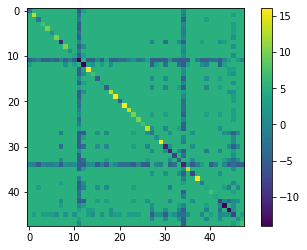

[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], -91., 1)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], -91., 1)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], -91., 1)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], -91., 1)
 ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0], -90., 1)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], -91., 1)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0

In [88]:
from openjij import SQASampler
sampler = SQASampler()

NassetsList = [48]#, 30, 36, 42, 48, 54, 60]
JF = 7.0

for Nassets in NassetsList:


    #相関係数などの準備
    Chart = CreateAssets(Nassets)
    Chart_pd = pd.DataFrame(Chart).T
    pairwise_corr = Chart_pd.corr(method='pearson')
    SR_list = list()
    for asset in Chart:
        SR_list.append(CalculateSharpeRatio(asset))

    #Bucketの翻訳
    SRBucket(SR_list)
    CorrelationBucket(pairwise_corr)
    #print(pairwise_corr)

    QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
    for i in  range(Nassets):
        for j in range(Nassets):
            QUBO[i][j] = pairwise_corr[i][j]
    for i in range(Nassets):
        QUBO[i][i] = QUBO[i][i] + SR_list[i]
    
    print(type(QUBO))
    import matplotlib.pyplot as plt
    plt.imshow(QUBO)
    plt.colorbar()
    plt.show()

    sampleset = sampler.sample_qubo(QUBO,num_reads=10)
    print(sampleset.record)



### Reverse Quantum Annealingの場合

<class 'numpy.ndarray'>


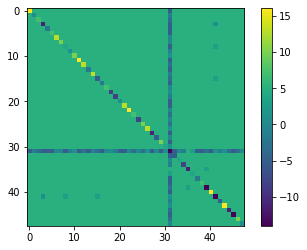

[([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], -50., 1)
 ([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], -50., 1)
 ([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], -50., 1)
 ([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], -50., 1)
 ([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], -50., 1)
 ([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], -49., 1)
 ([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [79]:
from openjij import SQASampler
sampler = SQASampler()

NassetsList = [48]#, 30, 36, 42, 48, 54, 60]


# RQA schedule
#timing = (0,1,2,3)
#Ratio = (1.0,0.38,0.38,1.0)
#schedule = list(zip(timing,Ratio))
#plt.plot(t,s)
#plt.show()

schedule0 = [
    [0.7, 5.0, 5]
]

schedule1 = [
    [0.7, 5.0,5],
    [0.38, 5.0,5],
    [0.38, 5.0,5],
    [1.0, 5.0,5]
]

for Nassets in NassetsList:

    #相関係数などの準備
    Chart = CreateAssets(Nassets)
    Chart_pd = pd.DataFrame(Chart).T
    pairwise_corr = Chart_pd.corr(method='pearson')
    SR_list = list()
    for asset in Chart:
        SR_list.append(CalculateSharpeRatio(asset))

    #Bucketの翻訳
    SRBucket(SR_list)
    CorrelationBucket(pairwise_corr)
    #print(pairwise_corr)


    QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
    for i in  range(Nassets):
        for j in range(Nassets):
            QUBO[i][j] = pairwise_corr[i][j]
    for i in range(Nassets):
        QUBO[i][i] = QUBO[i][i] + SR_list[i]
    
    print(type(QUBO))
    import matplotlib.pyplot as plt
    plt.imshow(QUBO)
    plt.colorbar()
    plt.show()

    sampleset = sampler.sample_qubo(QUBO,num_reads=10, schedule=schedule0)
    print(sampleset.record)

    print("")
    init_state = sampleset.record[-1][0]
    print(init_state)
    sampleset_RQA = sampler.sample_qubo(QUBO,num_reads=10, schedule=schedule1, initial_state = init_state)
    print(sampleset_RQA.record)


## 参考文献
1. Harry Markowitz, "Portfolio selection", The journal of finance, 7(1):77–91 (1952)
2. Davide Venturelli, Alexei Kondratyev, "Reverse Quantum Annealing Approach to Portfolio Optimization Problems", Quantum Machine Intelligence volume 1, pages17–30 (2019)
